In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [7]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [8]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [9]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [10]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [17]:
# Find the most recent date in the data set.
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
most_recent_date

('2017-08-23')

In [21]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Calculating the date one year from the last date in data set.
query_year = dt.date(2017,8,23) - dt.timedelta(days = 365)


# Perform a query to retrieve the data and precipitation scores
prcp_scores = session.query(measurement.date, measurement.prcp).\
                filter(measurement.date >= query_year).all()

prcp_scores[:5]

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0)]

In [23]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_scores, columns= ['date', 'precipitation'])
prcp_df.set_index('date', inplace = True)
# Sort the dataframe by date
prcp_df = prcp_df.sort_index()
prcp_df

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


In [24]:
#Cleaning up NaN entries
prcp_df = prcp_df.dropna(how='any') 
prcp_df

,precipitation
date,
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


<Figure size 720x504 with 0 Axes>

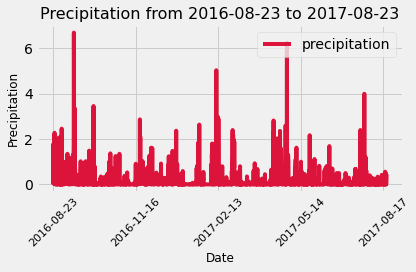

In [49]:
# Using Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize= (10,7))

prcp_df.plot(rot=45,color = 'crimson' )

plt.xticks(fontsize = 11)

plt.title(f'Precipitation from 2016-08-23 to 2017-08-23', fontsize = 16)
plt.xlabel ('Date', fontsize = 12)
plt.ylabel('Precipitation', fontsize = 12)
plt.tight_layout()

plt.savefig("precipitation_analysis.png")

In [53]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_stats = round(prcp_df.describe(),2)
summary_stats

,precipitation
count,2021.00
mean,0.18
std,0.46
min,0.00
25%,0.00
50%,0.02
75%,0.13
max,6.70


# Exploratory Station Analysis

In [55]:
# Design a query to calculate the total number stations in the dataset
total_stations= session.query(station.id).count()
total_stations

9

In [63]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations =  session.query(measurement.station, func.count(measurement.station)).\
                    group_by(measurement.station).\
                    order_by(func.count(measurement.station).desc()).all()

In [65]:
active_stations = pd.DataFrame(active_stations, columns= ['station', 'count'])
active_stations

,station,count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [71]:
# Using the most active station id from the previous query, calculate the lowest, highest, 
# and average temperature.
most_active_station = active_stations.station[0]

temp_active_station= session.query(func.min(measurement.tobs),
                                   func.max(measurement.tobs),
                                   func.avg(measurement.tobs)).\
                                   filter(measurement.station == most_active_station). all()
temp_active_station

[(54.0, 85.0, 71.66378066378067)]

In [78]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station
temp_observations = session.query(measurement.date, measurement.tobs).\
                filter(measurement.date >= query_year).\
                filter(measurement.station == most_active_station). all()

temp_obs = pd.DataFrame(temp_observations, columns= ['date','tobs'])
temp_obs.head()

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


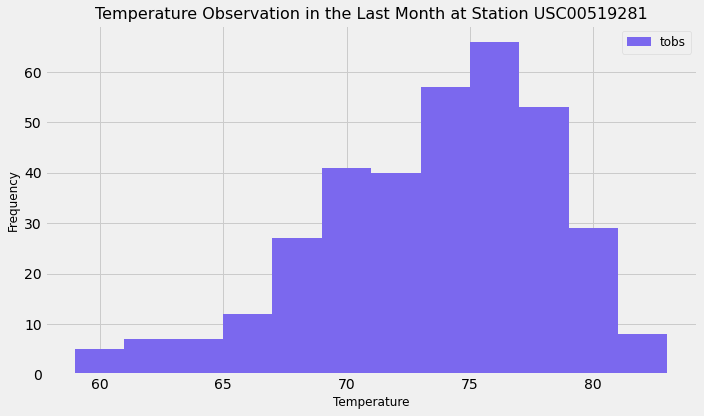

In [82]:
#plot the results as a histogram
plt.figure(figsize = (10,6))
plt.hist(temp_obs["tobs"], bins = 12, color = 'mediumslateblue')

plt.title((f'Temperature Observation in the Last Month at Station {most_active_station}'), fontsize = 16)
plt.xlabel("Temperature", fontsize = 12)
plt.ylabel("Frequency", fontsize = 12)
plt.legend(["tobs"], fontsize = 12)

plt.tight_layout()

plt.savefig("temperature_frequency.png")

# Close session

In [83]:
# Close Session
session.close()